In [2]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob 
import random
import os
import torch
from ultralytics import YOLO

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [4]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [5]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

In [6]:
import os
os.listdir('datasets/elderly/train/images/')

['bg_0.jpg',
 'bg_1.jpg',
 'bg_10.jpg',
 'bg_100.jpg',
 'bg_101.jpg',
 'bg_102.jpg',
 'bg_103.jpg',
 'bg_104.jpg',
 'bg_105.jpg',
 'bg_106.jpg',
 'bg_107.jpg',
 'bg_108.jpg',
 'bg_109.jpg',
 'bg_11.jpg',
 'bg_110.jpg',
 'bg_111.jpg',
 'bg_112.jpg',
 'bg_113.jpg',
 'bg_114.jpg',
 'bg_115.jpg',
 'bg_116.jpg',
 'bg_117.jpg',
 'bg_118.jpg',
 'bg_119.jpg',
 'bg_12.jpg',
 'bg_120.jpg',
 'bg_121.jpg',
 'bg_122.jpg',
 'bg_123.jpg',
 'bg_124.jpg',
 'bg_125.jpg',
 'bg_126.jpg',
 'bg_127.jpg',
 'bg_128.jpg',
 'bg_129.jpg',
 'bg_13.jpg',
 'bg_130.jpg',
 'bg_131.jpg',
 'bg_132.jpg',
 'bg_133.jpg',
 'bg_134.jpg',
 'bg_135.jpg',
 'bg_136.jpg',
 'bg_137.jpg',
 'bg_138.jpg',
 'bg_139.jpg',
 'bg_14.jpg',
 'bg_140.jpg',
 'bg_141.jpg',
 'bg_142.jpg',
 'bg_143.jpg',
 'bg_144.jpg',
 'bg_145.jpg',
 'bg_146.jpg',
 'bg_147.jpg',
 'bg_148.jpg',
 'bg_149.jpg',
 'bg_15.jpg',
 'bg_150.jpg',
 'bg_151.jpg',
 'bg_152.jpg',
 'bg_153.jpg',
 'bg_154.jpg',
 'bg_155.jpg',
 'bg_156.jpg',
 'bg_157.jpg',
 'bg_158.jpg',
 'bg_

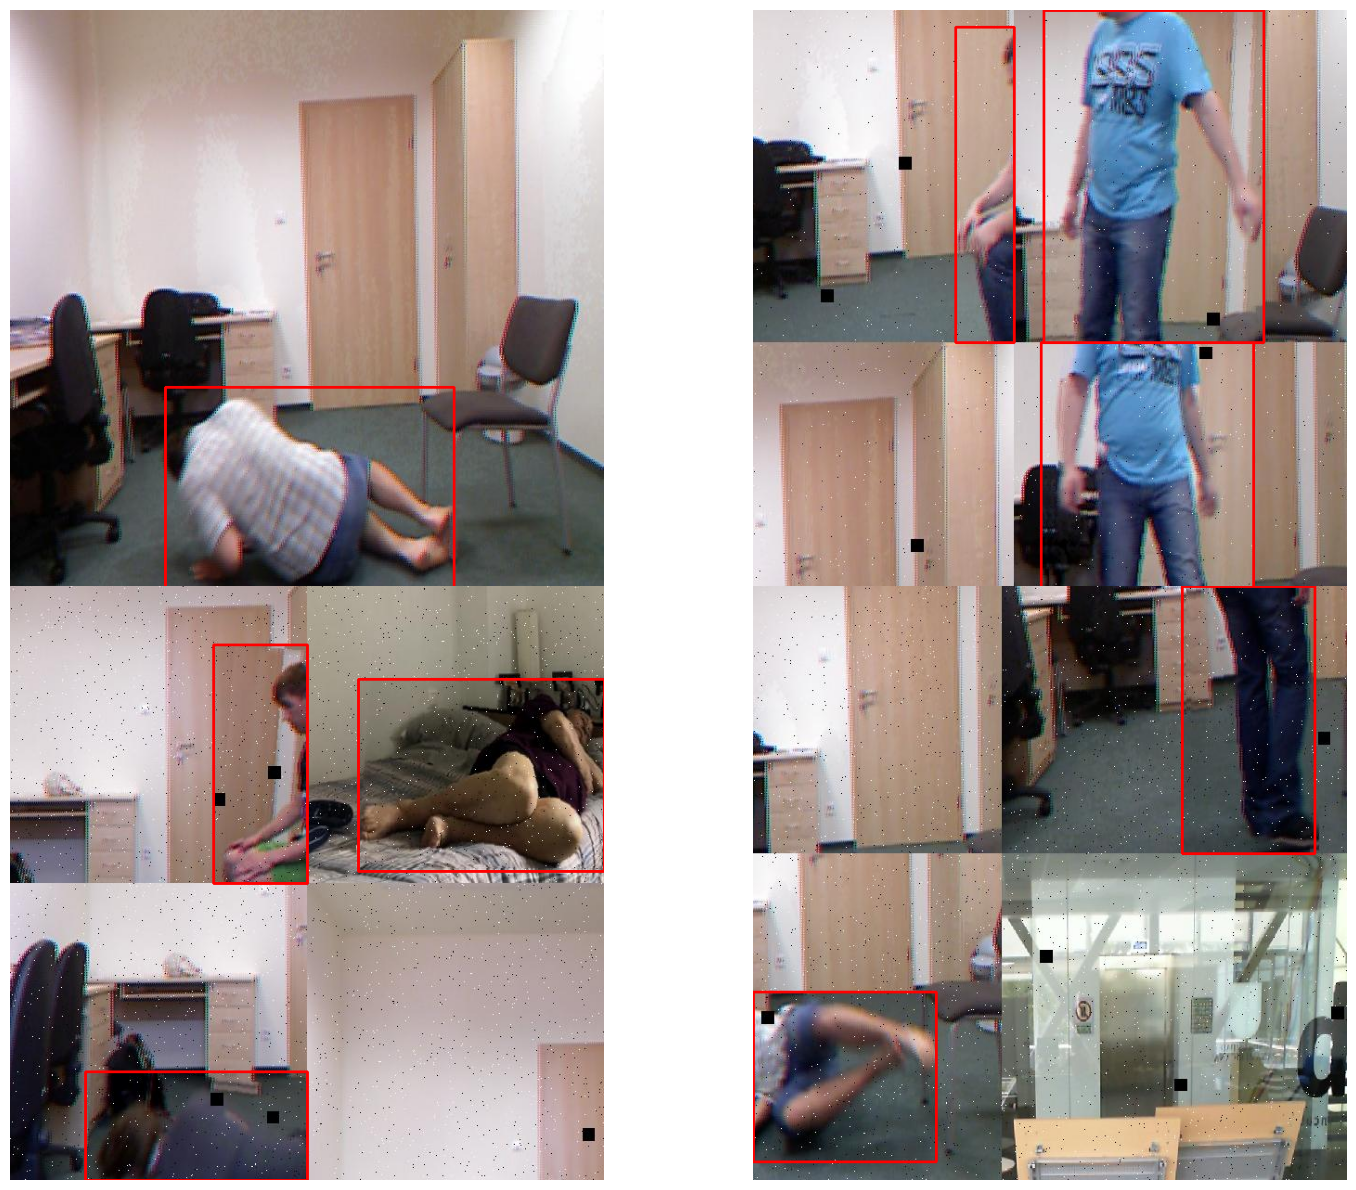

In [7]:
# Visualize a few training images.
plot(
    image_paths='datasets/elderly/train/images/', 
    label_paths='datasets/elderly/train/labels/',
    num_samples=4,
)

Create Yaml file

In [ ]:
%%writefile fall_v8.yaml
path: 'D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/'
train: 'D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/train/'
val: 'D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/valid/'
test: 'D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/test/'
# class names
names: 
  0: 'fall'
  1: 'notfallen'

Default value is 0 set 

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

# Train Model

Check is cuda is available

In [1]:
import torch

def is_cuda_available():
    return torch.cuda.is_available()

print(is_cuda_available())

True


In [7]:
from ultralytics import YOLO
from PIL import Image
from torchvision.utils import draw_bounding_boxes
import torch
from pathlib import Path
from ultralytics.utils import metrics

from ultralytics import YOLO
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA']='1' 
# print(os.environ['CUDA_LAUNCH_BLOCKING'])
# print(os.environ['TORCH_USE_CUDA_DSA'])

# Load the pre-trained model
model = YOLO("yolov8n.pt")

# Fine-tune the model
model.train(
    data='fall_v8.yaml', 
    epochs=10, 
    imgsz=1280, 
    batch=8,#works with batch=8
    save_period=1,
    device=[0],
    optimizer='auto',
)

New https://pypi.org/project/ultralytics/8.0.230 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.229 🚀 Python-3.10.11 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=fall_v8.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=1280, save=True, save_period=1, cache=False, device=[0], workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning D:\Python_Env\HumanFallDetection\final_fall\datasets\elderly\train\labels.cache... 4264 images, 227 backgrounds, 0 corrupt: 100%|██████████| 4464/4464 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 18, len(boxes) = 8099. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning D:\Python_Env\HumanFallDetection\final_fall\datasets\elderly\valid\labels.cache... 610 images, 5 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]


Plotting labels to D:\Python_Env\HumanFallDetection\runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/279 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "d:\Python_Env\HumanFallDetection\venv\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 37, in do_one_step
    data = pin_memory(data, device)
  File "d:\Python_Env\HumanFallDetection\venv\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 63, in pin_memory
    return type(data)({k: pin_memory(sample, device) for k, sample in data.items()})  # type: ignore[call-arg]
  File "d:\Python_Env\HumanFallDetection\venv\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 63, in <dictcomp>
    return type(data)({k: pin_memory(sample, device) for k, sample in data.items()})  # type: ignore[call-arg]
  File "d:\Python_Env\HumanFallDetection\venv\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 58, in pin_memory
    return data.pin_memory(device)
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Test Model with an Image

In [ ]:
from ultralytics import YOLO
import cv2
# Create a YOLO model
model = YOLO('best.pt')

# Run the YOLO model on the input
results = model.predict(source="D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/valid/images/img_104.jpg", show=True)

# Print the results
print(results)
cv2.waitKey(0)
cv2.destroyAllWindows()

Test Model with a Video

In [14]:
from ultralytics import YOLO
import cv2

# Create a YOLO model
model = YOLO('../final_fall/trained_models/best.pt')

# Define a video source
video_source = '../final_fall/VideoFolder/fall4.mp4'

# Create a video capture object
cap = cv2.VideoCapture(video_source)

# Check if the video capture object was created successfully
if not cap.isOpened():
    print("Error opening video file")

# Loop through the video
while cap.isOpened():
    # Capture frame-by-frame
    ret, frame = cap.read()

    # If the frame was captured successfully
    if ret:
        # Run the YOLO model on the frame
        results = model.predict(frame, show=True)

        # Print the results
        print(results)
        # Break the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Break the loop if the 'q' key is pressed
    else:
        break

# Release the video capture object
cap.release()

# Destroy all windows
cv2.destroyAllWindows()

# Release the video capture object
cap.release()

# Destroy all windows
cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: '..\\best.pt'

In [ ]:
!yolo task=detect mode=predict model=best.pt source=D:/Python_Env/HumanFallDetection/final_fall/datasets/elderly/valid/images imgsz=1280 name=yolov8n_v8_50e_infer1280

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('D:/Python_Env/HumanFallDetection/runs/detect/yolov8n_v8_50e_infer1280')